In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Commodities', min_assets=.2), 75, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-04-24 to 2019-07-08 - 21


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats

10


,len,mean,std,shrp,drawdown
Symbols,,,,,
BAR,47,0.981921,1.893431,0.497635,2.700990
GLD,47,0.974338,1.886535,0.495435,2.667662
SGOL,47,0.978546,1.901600,0.493723,2.692057
IAU,47,0.979142,1.925017,0.488027,2.716592
GLTR,47,0.692311,1.740959,0.374867,3.584793
PALL,47,1.177593,3.374073,0.337251,11.245765
PSLV,47,0.499141,2.006706,0.228961,4.805911
DBA,47,0.284842,1.702148,0.144030,4.366544
SIVR,47,0.139768,1.745984,0.057323,4.517453


evicted PSLV 0.8651660310556918
evicted PALL 0.2949164778052119
retry backlogs ['GLTR', 'IAU', 'SLV', 'SGOL', 'SIVR', 'GLD'] at 0.905 - 0.571
evicted SIVR 0.9012433722068453
retry backlogs ['IAU', 'SGOL', 'SLV', 'GLTR', 'GLD'] at 0.91 - 0.571
evicted SLV 0.906306046974189
retry backlogs ['IAU', 'SGOL', 'GLTR', 'GLD'] at 0.915 - 0.571
retry backlogs ['SGOL', 'IAU', 'GLTR', 'GLD'] at 0.92 - 0.571
retry backlogs ['SGOL', 'IAU', 'GLTR', 'GLD'] at 0.925 - 0.571
retry backlogs ['SGOL', 'IAU', 'GLTR', 'GLD'] at 0.93 - 0.571
retry backlogs ['SGOL', 'IAU', 'GLTR', 'GLD'] at 0.935 - 0.571
retry backlogs ['SGOL', 'IAU', 'GLTR', 'GLD'] at 0.9400000000000001 - 0.571
retry backlogs ['SGOL', 'IAU', 'GLTR', 'GLD'] at 0.9450000000000001 - 0.571
retry backlogs ['SGOL', 'IAU', 'GLTR', 'GLD'] at 0.9500000000000001 - 0.571
retry backlogs ['SGOL', 'IAU', 'GLTR', 'GLD'] at 0.9550000000000001 - 0.571
evicted GLTR 0.9511606177735401
retry backlogs ['SGOL', 'IAU', 'GLD'] at 0.9600000000000001 - 0.571
retry back

,count,mean,std,min,25%,50%,75%,max,shrp,drawdown
Portfolio,47.0,0.727429,1.214611,-1.745360,-0.390645,0.656471,1.285250,3.418094,0.566228,2.043368
BAR,47.0,0.981921,1.893431,-2.494698,-0.039274,0.488719,1.564185,5.833955,0.497635,2.700990
DBA,47.0,0.284842,1.702148,-3.039707,-0.958965,0.000000,1.955462,3.729897,0.144030,4.366544


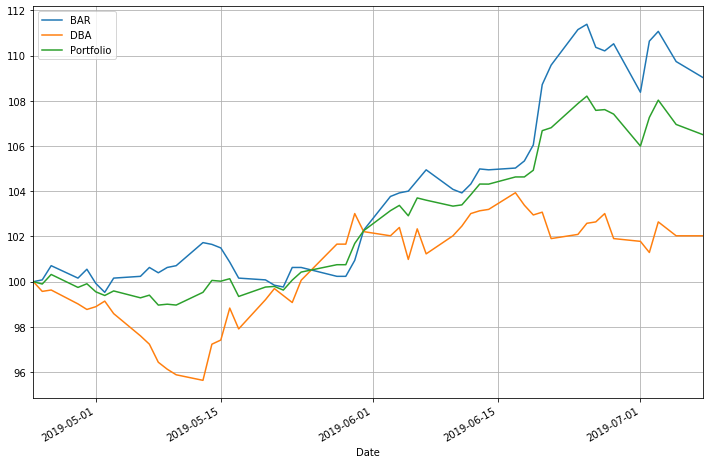

In [5]:
quote.setup_mask(stats.index)
ratio, shrp = quote.optimize_portfolio(.1)
print(ratio, shrp)
quote.setup_mask(ratio)
quote.graph(ratio)